In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
import os
from torch_geometric.datasets import TUDataset
import os.path as osp
from torch_geometric.loader import DenseDataLoader
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool,dense_mincut_pool
import torch_geometric.transforms as T
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pandas as pd
import random
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear,BatchNorm1d
import torch.nn.functional as F
from math import ceil
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
from torch_geometric.loader import DenseDataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv, DenseGraphConv
%matplotlib inline

In [3]:
path_to_LH = '../data/Oasis_original_new_with_dummy_LH/modified_graphs/'
path_to_RH = '../data/Oasis_original_new_with_dummy_RH/modified_graphs/'

In [4]:
list_graphs_LH = gp.load_graphs_in_list(path_to_LH)
list_graphs_RH = gp.load_graphs_in_list(path_to_RH)

In [5]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [6]:
def create_pyg_graphs(list_graphs,graph_labels):
    
    sulcal_dataset = []
    
    for i,g in enumerate(list_graphs):
        
        graph_remove_dummy_nodes(g) # remove dummy nodes
        g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
        
        attr_coords = np.array(list(nx.get_node_attributes(g,'sphere_3dcoords').values()))
        attr_basin_area = np.array(list(nx.get_node_attributes(g,'basin_area').values())).reshape([len(g),1])
        attr_basin_thickness = np.array(list(nx.get_node_attributes(g,'basin_thickness').values())).reshape([len(g),1])
        attr_depth = np.array(list(nx.get_node_attributes(g,'depth').values())).reshape([len(g),1])
        attr_concat = np.concatenate((attr_coords,attr_basin_area,attr_basin_thickness,attr_depth),axis = 1)
        
        x = torch.tensor(attr_concat,dtype=torch.float)
        #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
        
        y = torch.tensor(graph_labels[i],dtype=torch.long)
        
        edge_index = torch.tensor(list(g.edges))
        sulcal_dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))
        
    return sulcal_dataset
    

In [7]:
# Convert networkx graphs to pyg graphs

graph_labels_LH = np.zeros([len(list_graphs_LH)])
graph_labels_RH = np.ones([len(list_graphs_RH)])

sulcal_dataset_LH = create_pyg_graphs(list_graphs_LH,graph_labels_LH)
sulcal_dataset_RH = create_pyg_graphs(list_graphs_RH,graph_labels_RH)

sulcal_dataset = sulcal_dataset_LH + sulcal_dataset_RH

/tmp/ipykernel_72068/891738680.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(graph_labels[i],dtype=torch.long)


In [8]:
random.shuffle(sulcal_dataset)

In [9]:
train_dataset = sulcal_dataset[:len(sulcal_dataset)-40]
test_dataset = sulcal_dataset[len(sulcal_dataset)-40:]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # dense data loader for using adjacency
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [10]:
test_dataset

[Data(x=[89, 6], edge_index=[2, 251], y=0),
 Data(x=[91, 6], edge_index=[2, 259], y=0),
 Data(x=[94, 6], edge_index=[2, 267], y=0),
 Data(x=[86, 6], edge_index=[2, 243], y=1),
 Data(x=[94, 6], edge_index=[2, 265], y=0),
 Data(x=[96, 6], edge_index=[2, 273], y=1),
 Data(x=[94, 6], edge_index=[2, 265], y=0),
 Data(x=[94, 6], edge_index=[2, 268], y=1),
 Data(x=[89, 6], edge_index=[2, 250], y=1),
 Data(x=[86, 6], edge_index=[2, 239], y=0),
 Data(x=[91, 6], edge_index=[2, 256], y=0),
 Data(x=[89, 6], edge_index=[2, 252], y=0),
 Data(x=[85, 6], edge_index=[2, 242], y=1),
 Data(x=[91, 6], edge_index=[2, 262], y=1),
 Data(x=[88, 6], edge_index=[2, 248], y=1),
 Data(x=[99, 6], edge_index=[2, 281], y=1),
 Data(x=[83, 6], edge_index=[2, 234], y=0),
 Data(x=[89, 6], edge_index=[2, 253], y=1),
 Data(x=[83, 6], edge_index=[2, 234], y=1),
 Data(x=[85, 6], edge_index=[2, 243], y=1),
 Data(x=[85, 6], edge_index=[2, 240], y=0),
 Data(x=[88, 6], edge_index=[2, 252], y=1),
 Data(x=[89, 6], edge_index=[2, 

In [11]:
num_node_features = train_dataset[0].num_features
num_node_features

6

In [12]:
# # Create MLP Model

# class MLP(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, hidden_channels=16):        
#         super(MLP, self).__init__()
#         torch.manual_seed(12345)
        
#         self.emb_dim = 8
        
#         self.lin1 = Linear(in_channels, hidden_channels)
#         self.lin2 = Linear(hidden_channels, hidden_channels)
#         self.lin3 = Linear(hidden_channels, out_channels)
        

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
        
#         emb = self.lin1(x)
#         x = emb.relu()
#         emb = self.lin2(x)
#         x = emb.relu()
#         g_emb = global_mean_pool(x, batch)
#         out = self.lin3(g_emb)
        
#         return out, g_emb, emb, x

    
# model = MLP(num_node_features, 2)
# print(model)

In [13]:
# # Create GAT Model

# class GAT(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, hidden_channels=32):        
#         super(GAT, self).__init__()
#         torch.manual_seed(12345)
#         self.in_head = 2
#         self.out_head = 1
        
#         self.emb_dim = 8
        
        
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=self.in_head)
#         self.conv2 = GATConv(hidden_channels*self.in_head, hidden_channels,concat=False)
#         self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
#         self.lin = Linear(self.emb_dim, out_channels)
        

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         emb,attn_weights = self.conv3(x, edge_index,return_attention_weights=True)

#         # 2. Readout layer
#         g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels] TopKPooling
#         #g_emb = TopKPooling(emb, batch)

#         # 3. Apply a final classifier
#         out = F.dropout(g_emb, p=0.5, training=self.training)
#         out = self.lin(out)
        
#         return out, g_emb, emb, attn_weights

    
# model = GAT(num_node_features, 2)
# print(model)

In [14]:
class mincutnet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=16):
        super(mincutnet, self).__init__()
        
        self.in_head = 1
        self.out_head = 1
        
        self.emb_dim = 16 # embedding dimension
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, self.emb_dim, heads=self.in_head,dropout=0.2)

#        self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
        
        num_of_centers =  20
        self.pool1 = Linear(self.emb_dim, num_of_centers) # The degree of the node belonging to any of the centers
        
        self.conv3 = DenseGraphConv(self.emb_dim, self.emb_dim)

        #self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(self.emb_dim, out_channels)

    def forward(self, x, edge_index, batch): 
        
        x = F.relu(self.conv1(x, edge_index))
        #x = F.relu(self.conv2(x, edge_index))
        node_emb, attn_weights = self.conv2(x, edge_index,return_attention_weights=True)
        x = node_emb.relu()

        x, mask = to_dense_batch(x, batch) 
        
        adj = to_dense_adj(edge_index, batch) 
        s = self.pool1(x)

        
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask) 
        x = self.conv3(x, adj) 
        g_emb = x.mean(dim=1) 
        #x = F.relu(self.lin1(x)) 
        out = self.lin2(g_emb)
        return out, g_emb, node_emb, attn_weights

model = mincutnet(num_node_features, 2)
print(model)

mincutnet(
  (conv1): GCNConv(6, 16)
  (conv2): GATConv(16, 16, heads=1)
  (pool1): Linear(in_features=16, out_features=20, bias=True)
  (conv3): DenseGraphConv(16, 16)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [15]:
#model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        out, g_emb, node_emb, s = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    
    predictions = []
    
    for data in loader:
        out, g_emb, node_emb, s =  model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        predictions.append(pred)
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
    test_acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
            
    return test_acc,model, predictions   

In [16]:
train_acc_lst = []
test_acc_lst = []

best_accu = 0.0

for epoch in range(1, 99):
    train()
    train_acc,_ ,_= test(train_loader)
    train_acc_lst.append(train_acc)
    
    test_acc, model,_ = test(test_loader)
    
    if test_acc > best_accu:
        
        print('Saving Model ... ')
        torch.save(model.state_dict(), 'OASIS_best.model')
        best_accu = test_acc
        
    test_acc_lst.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Saving Model ... 
Epoch: 001, Train Acc: 0.4829, Test Acc: 0.5750
Epoch: 002, Train Acc: 0.4915, Test Acc: 0.4750
Epoch: 003, Train Acc: 0.5641, Test Acc: 0.4750
Epoch: 004, Train Acc: 0.5641, Test Acc: 0.5750
Epoch: 005, Train Acc: 0.5726, Test Acc: 0.5750
Epoch: 006, Train Acc: 0.5684, Test Acc: 0.5250
Epoch: 007, Train Acc: 0.6154, Test Acc: 0.5250
Epoch: 008, Train Acc: 0.5427, Test Acc: 0.5750
Epoch: 009, Train Acc: 0.5983, Test Acc: 0.5500
Epoch: 010, Train Acc: 0.6111, Test Acc: 0.5750
Epoch: 011, Train Acc: 0.6068, Test Acc: 0.5500
Epoch: 012, Train Acc: 0.6368, Test Acc: 0.5750
Saving Model ... 
Epoch: 013, Train Acc: 0.6368, Test Acc: 0.6000
Epoch: 014, Train Acc: 0.6325, Test Acc: 0.4750
Epoch: 015, Train Acc: 0.6197, Test Acc: 0.5500
Epoch: 016, Train Acc: 0.6410, Test Acc: 0.5500
Epoch: 017, Train Acc: 0.6410, Test Acc: 0.5250
Epoch: 018, Train Acc: 0.6453, Test Acc: 0.5250
Epoch: 019, Train Acc: 0.6496, Test Acc: 0.6000
Epoch: 020, Train Acc: 0.6795, Test Acc: 0.5250
Savi

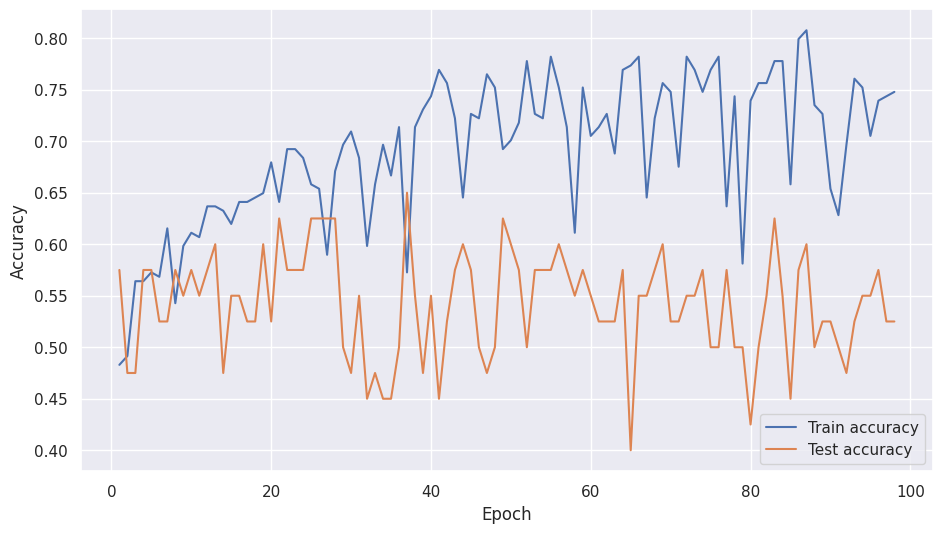

In [17]:
sns.set(rc={'figure.figsize':(11,6)})
epochs = np.arange(1,99,1)
plt.plot(epochs, train_acc_lst,label='Train accuracy')
plt.plot(epochs, test_acc_lst, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

In [18]:
model.load_state_dict(torch.load('OASIS_best.model'))

<All keys matched successfully>

In [39]:
avg_feature_coords = []
avg_feature_labels = []

for d in sulcal_dataset:
    avg_feature_coords.append(np.mean(d.x.detach().numpy(),axis=0))
    avg_feature_labels.append(d.y.detach().numpy())
    
avg_feature_coords = np.array(avg_feature_coords)
avg_feature_labels = np.array(avg_feature_labels)

In [40]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)

tsne_graph = tsne.fit_transform(avg_feature_coords)
tsne_graph.shape

(274, 2)

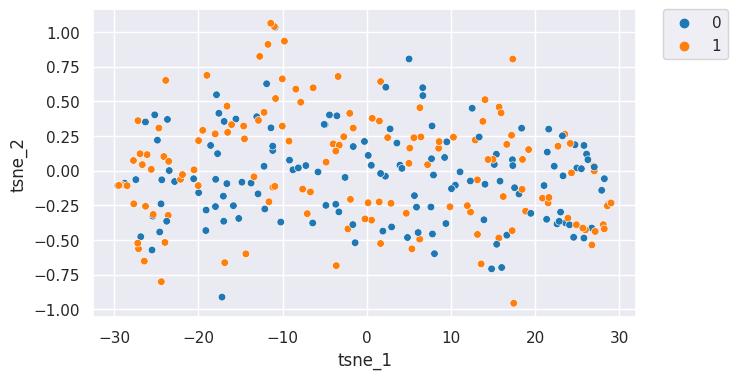

In [41]:
sns.set(rc={'figure.figsize':(7,4)})

tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':avg_feature_labels})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=30,palette='tab10')

# lim = (tsne_graph.min()-5, tsne_graph.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [156]:
# eval emb mixed with reference graph
#all_graph = DataLoader(eval_set+reference_set, batch_size= len(eval_set) + len(reference_set), shuffle=False)

sulc_dataset = sulcal_dataset_LH + sulcal_dataset_RH

all_graph = DataLoader(sulc_dataset, batch_size= len(sulc_dataset), shuffle=False)

for data in all_graph:
      out, g_emb, node_emb, attn_weights = model(data.x, data.edge_index, data.batch)
#   prob,g_emb,out_emb,attn_weights = model(data.x, data.edge_index, data.batch) o


#out_emb = out_emb.detach().numpy()
g_emb = g_emb.detach().numpy()

In [52]:
tsne_emb = tsne.fit_transform(g_emb)
tsne_emb.shape

(274, 2)

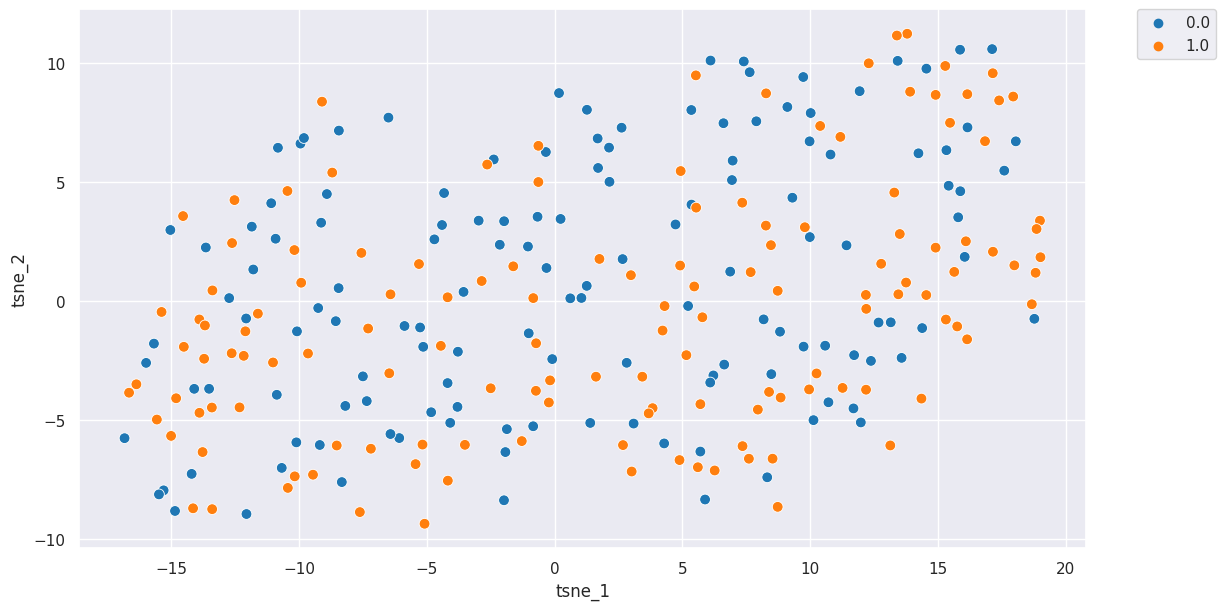

In [158]:
sns.set(rc={'figure.figsize':(13,7)})

tsne_graph_df = pd.DataFrame({'tsne_1': tsne_emb[:,0], 'tsne_2': tsne_emb[:,1], 'label':list(graph_labels_LH) + list(graph_labels_RH)})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=60,palette='tab10')

# lim = (tsne_graph.min()-5, tsne_graph.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [163]:
len_edges = len(data.edge_index[0])
attn_matrix = np.zeros([len_edges,len_edges])

counter = 0
for a,b in zip(data.edge_index[0],data.edge_index[1]):
    
    attn_matrix[int(a),int(b)] = float(attn_weights[1][counter])  # float(np.mean(attn_weights[1][counter].detach().numpy()))  # mean for multi-head attention 
    
    counter += 1  

In [165]:
# Extract attn_weights for each graph

init_count = 0
attn_mat_all=[]

list_graphs = list_graphs_LH + list_graphs_RH

for g in list_graphs:
    
    nb_nodes = len(g) + init_count
    #print('len(g), init_count : ', len(g), init_count)
    
    mat = attn_matrix[init_count:nb_nodes, init_count:nb_nodes]
    attn_mat_all.append(mat)
    #print(range(init_count,nb_nodes, len(g)))
    
    init_count+=len(g)

<AxesSubplot:>

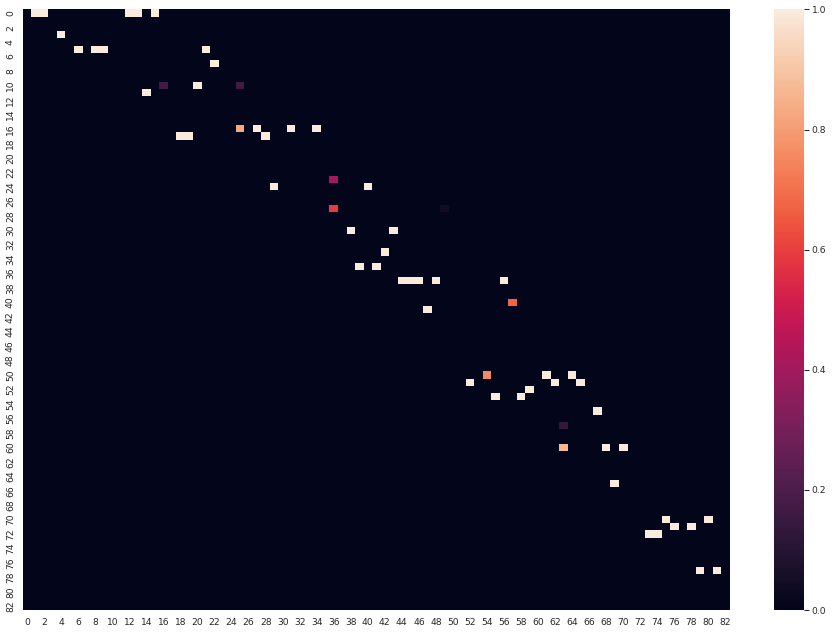

In [182]:
figure(figsize=(19, 13), dpi=60)
sns.heatmap(attn_mat_all[1])

In [178]:
#pickle.dump(attn_mat_all, open( "attn_mat_both_hemi.pickle", "wb" ))

In [179]:
len(attn_mat_all)

274

In [186]:
g.nodes.data()[0]

{'vertex_index': 6414,
 'sphere_3dcoords': [17.785308837890625,
  -94.89070129394531,
  -26.06601905822754],
 'sphere_coords': [-1.3855165243148804, 1.8345023393630981],
 'basin_label': 202.0,
 'basin_area': 954.9909,
 'depth': -1.0174633,
 'basin_thickness': 2.0496299266815186,
 'ico100_7_vertex_index': 30475,
 'is_dummy': False}

In [ ]:
for g in list_graphs:
	gp.remove_dummy_nodes(g)

	for edge in g.edges:

		if nx.get_edge_attributes(g,'attn_weight')[edge] < 0.5: # threshold attn_weights
			g.remove_edge(edge[0],edge[1])

	deg_attn = dict(g.degree)

	nx.set_node_attributes(g, deg_attn,'deg_attn')

In [191]:
nx.get_node_attributes(g,'basin_area')

{0: 954.9909,
 1: 1594.6194,
 2: 390.709,
 3: 354.9519,
 4: 700.2247,
 5: 135.33223,
 6: 322.6928,
 7: 1604.5175,
 8: 555.11676,
 9: 63.296513,
 10: 2129.846,
 11: 596.7197,
 12: 244.79362,
 13: 2000.7084,
 14: 912.2326,
 15: 317.38794,
 16: 1537.7195,
 17: 462.62253,
 18: 1052.1738,
 19: 1476.2434,
 20: 432.77145,
 21: 1918.1998,
 22: 1340.7058,
 23: 332.0391,
 24: 72.32882,
 25: 2059.0815,
 26: 155.6133,
 27: 1905.6693,
 28: 2506.6125,
 29: 2446.4417,
 30: 294.57755,
 31: 1552.2842,
 32: 415.87845,
 33: 669.6947,
 34: 1426.4138,
 35: 123.22874,
 36: 1452.8258,
 37: 981.2184,
 38: 526.4644,
 39: 1949.1636,
 40: 2914.9692,
 41: 2175.3618,
 42: 682.7931,
 43: 642.4244,
 44: 1372.1395,
 45: 296.91214,
 46: 51.83963,
 47: 1914.9742,
 48: 1843.7876,
 49: 835.73975,
 50: 1018.934,
 51: 1092.5172,
 52: 626.46484,
 53: 1542.4895,
 54: 367.38904,
 55: 326.58643,
 56: 92.112404,
 57: 175.8429,
 58: 1150.38,
 59: 579.5163,
 60: 3099.6514,
 61: 895.06287,
 62: 427.72266,
 63: 1740.8243,
 64: 503.